# PyKX Query Components
Query all components, RDB, HDB, and Gateway.


In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import os
import subprocess
import boto3
import json
import datetime

from env import *
import pykx as kx

from managed_kx import *

from basictick_setup import *

In [2]:
# triggers credential get
session=None

try:
    # aws: use ada for credentials
    os.system(["which", "ada"])
    os.system(f"ada credentials update --account={ACCOUNT_ID} --provider=isengard --role=Admin --once")
except: 
    None

if AWS_ACCESS_KEY_ID is None:
    print("Using Defaults ...")
    # create AWS session: using access variables
    session = boto3.Session()
else:
    print("Using variables ...")
    session = boto3.Session(
        aws_access_key_id=AWS_ACCESS_KEY_ID,
        aws_secret_access_key=AWS_SECRET_ACCESS_KEY,
        aws_session_token=AWS_SESSION_TOKEN
    )

# create finspace client
client = session.client(service_name='finspace', endpoint_url=ENDPOINT_URL)

Using variables ...


# Start q process that subscribes to CALC engine

In [3]:
CODEBASE="basictick"

# get the connection string
conn_str = get_kx_connection_string(client, environmentId=ENV_ID, clusterName=CALC_CLUSTER_NAME, userName=KDB_USERNAME, boto_session=session)

# populate the environment variable with connection string
os.putenv("CONN_STR", conn_str)
os.putenv("SUBSCRIBER_PORT", f"{SUBSCRIBER_PORT}")
os.putenv("SSL_VERIFY_SERVER", "No")

os.putenv("SUBSCRIBER_MODE", "trade_last") # trade_last OR trade_vwap OR trade_last

# start q process feedmkdb to connect to the TP at $TP_CONN
subprocess.Popen(f"cd {CODEBASE}; QHOME=/home/ec2-user/q/ QLIC=/home/ec2-user/q/lic nohup /home/ec2-user/q/l64/q kxtaqsubscriber.q -p $SUBSCRIBER_PORT -endpoint $CONN_STR -mode $SUBSCRIBER_MODE", shell=True)
print(conn_str)
print(SUBSCRIBER_PORT)

# wait for feedhandler to start doing its thing
time.sleep(2)

:tcps://vpce-02948264b1a3b6d4b-g1suadhu.vpce-svc-0bec396c2ede1e440.us-east-1.vpce.amazonaws.com:443:cgervin:Host=vpce-02948264b1a3b6d4b-g1suadhu.vpce-svc-0bec396c2ede1e440.us-east-1.vpce.amazonaws.com&Port=443&User=cgervin&Action=finspace%3AConnectKxCluster&X-Amz-Security-Token=IQoJb3JpZ2luX2VjEL%2F%2F%2F%2F%2F%2F%2F%2F%2F%2F%2FwEaCXVzLWVhc3QtMSJHMEUCIFLeuVBfF7YXr%2F988n4KHFotAigKDTO8CMcuM3yq%2B3PlAiEA3TmEDTx%2B6lDelc52pPPMWR0qyEGlXaor%2BhFBxI7WDcIq%2BAIIGBABGgw1OTA3ODA2MTUyNjQiDND%2B8VRaEJZkGQRuQSrVAqnoh8yUH0ezeffqrpICYfrhMT190uBuXQLHPkSg09WZZ040xNUmiZZuCf%2BlJSkLN2XQMxlXTK2ZGFFvumOZ9LOptFfgmfpM256nnug17br4yIRwYEGqLBfYvUKJGD6KQ%2Bf52x%2FrOj5fWtx61mVRaZxtxBHd277GUSHocGoVWJTeiNAEySFvFYNPEGsX89GiISqGh8RR%2BKuWCQToSkIubZEv8Q88fz7CguwV6dYjulSLfu0Ts47a4IUVpg2o00abTm7pQbB3JVGxqdMIWlUkZR9D0Sf8elnyBFVfV%2BjXfszmnauP3tCKVozPz9V7ZSo%2BXjr1R34LKHpeAeLOVbvsAH7E1x1NXZfbgAX9GN2jC7FGr1vAFzqHofFP%2BUN51xHGSVmMY6rKje6sKa14UL3u3zIjpnn%2BoUAjBMtW9GjPTveYlMM835foGh5TQy2wv%2BsS%2FuNjHqqcMO%2FcvrEGOr8BYcHVt

In [4]:
%%q 
profile:hopen`::5040
percentile:{(asc x) floor y*count x}

results:{
        select 
                 counter:count i, 
                 max_latency:max source_to_consumer_latency, 
                 latency_p50:percentile[source_to_consumer_latency;.50], 
                 latency_p90:percentile[source_to_consumer_latency;.90], 
                 latency_p99:percentile[source_to_consumer_latency;.99], 
                 "n"$avg source_to_calc_latency, 
                 "n"$avg source_to_consumer_latency 
         from profile".perf.stats"
 }

In [7]:
results = kx.q('results[]').pd()
results

,counter,max_latency,latency_p50,latency_p90,latency_p99,source_to_calc_latency,source_to_consumer_latency
0,15,0 days 00:00:00.006518730,0 days 00:00:00.006518730,0 days 00:00:00.006518730,0 days 00:00:00.006518730,0 days 00:00:00.005980121,0 days 00:00:00.006518730


In [9]:
stats = kx.q('profile".perf.stats"').pd()
stats

,receiveTime,source_to_calc_latency,source_to_consumer_latency
0,2024-04-29 14:28:07.144952103,0 days 00:00:00.005980121,0 days 00:00:00.006518730
1,2024-04-29 14:28:07.144952103,0 days 00:00:00.005980121,0 days 00:00:00.006518730
2,2024-04-29 14:28:07.144952103,0 days 00:00:00.005980121,0 days 00:00:00.006518730
3,2024-04-29 14:28:07.144952103,0 days 00:00:00.005980121,0 days 00:00:00.006518730
4,2024-04-29 14:28:07.144952103,0 days 00:00:00.005980121,0 days 00:00:00.006518730
...,...,...,...
130,2024-04-29 14:29:27.147916088,0 days 00:00:00.005989166,0 days 00:00:00.006657403
131,2024-04-29 14:29:27.147916088,0 days 00:00:00.005989166,0 days 00:00:00.006657403
132,2024-04-29 14:29:27.147916088,0 days 00:00:00.005989166,0 days 00:00:00.006657403
133,2024-04-29 14:29:27.147916088,0 days 00:00:00.005989166,0 days 00:00:00.006657403


In [10]:
import matplotlib.pyplot as plt

def plot_time_vs_timedelta(dataframe, x_column, y_column):
  # Convert timedelta to seconds for plotting
    dataframe['y_seconds'] = dataframe[y_column].dt.total_seconds()

    plt.figure(figsize=(10,6))
    # Plot
    plt.plot(dataframe[x_column], dataframe['y_seconds'])
    
    # Set labels and title
    plt.xlabel('Time')
    plt.ylabel('Time Delta (seconds)')
    plt.title('Time vs Time Delta')

    # Show plot
    plt.show()

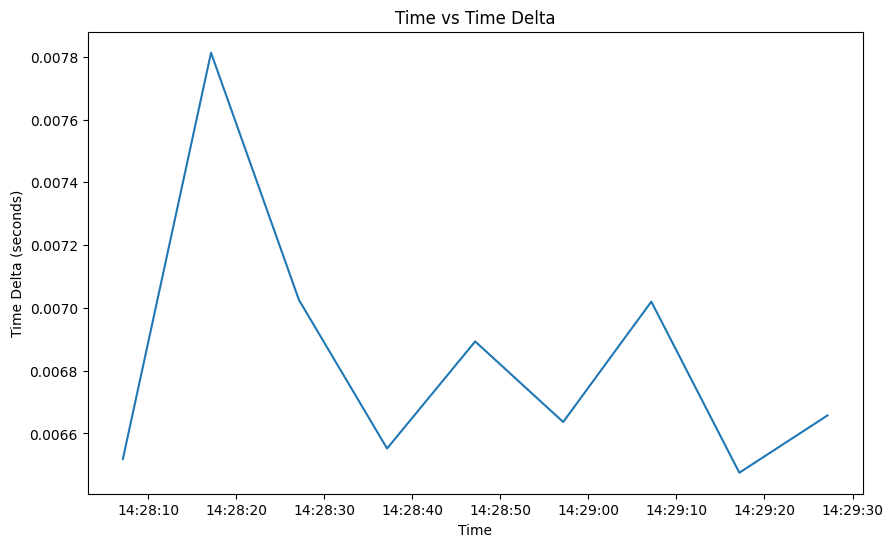

latency from FH -> FinSpace -> External Subscriber:  ,0D00:00:00.006712924


In [11]:
plot_time_vs_timedelta(stats,'receiveTime','source_to_consumer_latency')